In [10]:
import simpy
import random
import pandas as pd

# List to store the waiting time of each passenger
waiting_time_list = []
# Counter to track the number of passengers currently waiting
waiting_passengers = 0
# Interval for calculating average waiting time (15 minutes in seconds)
time_interval = 15 * 60
# List to store waiting times for each interval
waiting_time_intervals = []
# List to store the average waiting time for each interval
average_waiting_times = []
time_intervals_start = []  # 存储每个时间段的开始时间

def generate_processing_time():
    # Generates processing time for a passenger based on exponential distribution
    #15/45*60 = 20
    return random.expovariate(1 / 20.0)

def security_check(env, passenger_id, security_lanes, current_lane):
    global waiting_passengers, waiting_time_intervals

    arrival_time = env.now
    print(f"Passenger {passenger_id} arrived at {arrival_time}")
    waiting_passengers += 1

    with current_lane.request() as request:
        yield request
        processing_start = env.now
        yield env.timeout(generate_processing_time())
        waiting_time = processing_start - arrival_time
        waiting_time_list.append(waiting_time)
        waiting_passengers -= 1
        waiting_time_intervals[-1].append(waiting_time)
        print(f"Passenger {passenger_id} completed processing at {env.now} (Waiting time: {waiting_time} seconds)")

def passenger_generator(env, security_lanes, passengers_data):
    # Generates passengers based on the arrival time data
    for _, passenger in passengers_data.iterrows():
        passenger_id = passenger['Id']
        arrival_time = passenger['ArrivalTime']
        yield env.timeout(arrival_time - env.now)
        current_lane = security_lanes[-1]
        env.process(security_check(env, passenger_id, security_lanes, current_lane))

def adjust_security_lanes(env, security_lanes, security_data):
    # Adjusts the number of security lanes based on the provided schedule
    for _, row in security_data.iterrows():
        time, lanes = row['Time'], row['Lanes']
        yield env.timeout(time - env.now)
        new_lane = simpy.Resource(env, capacity=lanes)
        security_lanes.append(new_lane)

def calculate_average_waiting_time(env):
    global time_intervals_start
    current_time = 0
    while True:
        yield env.timeout(time_interval)
        current_time += time_interval  # Update the current time to the start of the new time period
        if waiting_time_intervals[-1]: # Make sure the list is not empty
            avg_waiting_time = sum(waiting_time_intervals[-1]) / len(waiting_time_intervals[-1])
            average_waiting_times.append(avg_waiting_time)
        else:
            average_waiting_times.append(0)
        time_intervals_start.append(current_time - time_interval)  # Record the start time of the time period
        waiting_time_intervals.append([])

def run_simulation(sim_time, passengers_data, security_data):
    global waiting_passengers, waiting_time_intervals, average_waiting_times

    env = simpy.Environment()
    security_lanes = [simpy.Resource(env, capacity=security_data['Lanes'].iloc[0])]
    waiting_time_intervals.append([])

    env.process(passenger_generator(env, security_lanes, passengers_data))
    env.process(adjust_security_lanes(env, security_lanes, security_data))
    env.process(calculate_average_waiting_time(env))
    
    env.run(until=sim_time)
    # Convert average wait times to DataFrame
    df_avg_waiting_times = pd.DataFrame(average_waiting_times, columns=['Average Waiting Time'])
    return df_avg_waiting_times

# data import
passengers_data = pd.read_csv('passengers_0.csv').sort_values(by='ArrivalTime')
security_data = pd.read_csv('security.csv')

# run
average_waiting_time_df = run_simulation(40000, passengers_data, security_data)

average_waiting_time_df = pd.DataFrame({
    'Average Waiting Time': average_waiting_times
}, index=time_intervals_start)


Passenger 7W4SUIW8P60C9EZHVKY7 arrived at 8233.11798182214
Passenger 7W4SUIW8P60C9EZHVKY7 completed processing at 8246.030376494793 (Waiting time: 0.0 seconds)
Passenger TGR0H5TWSF84MFMQUX8C arrived at 8276.390512008185
Passenger TGR0H5TWSF84MFMQUX8C completed processing at 8285.827770740234 (Waiting time: 0.0 seconds)
Passenger 9U7304Z48YAGBHLRQ2C1 arrived at 8868.483377069739
Passenger KMIZ1FTYWSB0LAQWT1YX arrived at 8892.912111878226
Passenger 9U7304Z48YAGBHLRQ2C1 completed processing at 8903.547505737084 (Waiting time: 0.0 seconds)
Passenger KMIZ1FTYWSB0LAQWT1YX completed processing at 8920.494048927261 (Waiting time: 10.635393858858151 seconds)
Passenger EH1RELRCS1FWEAKAN0XN arrived at 9024.329169188
Passenger EH1RELRCS1FWEAKAN0XN completed processing at 9025.36340311474 (Waiting time: 0.0 seconds)
Passenger NV7KUEARJML65WN17FCG arrived at 9106.285121659166
Passenger NV7KUEARJML65WN17FCG completed processing at 9125.725827574894 (Waiting time: 0.0 seconds)
Passenger 5PPT0WWE5IP8IF

In [11]:
average_waiting_time_mean = average_waiting_time_df['Average Waiting Time'].mean()
average_waiting_time_mean

29.04239512610743

In [13]:
average_waiting_time_df["Time in hour"] = average_waiting_time_df.index/3600
average_waiting_time_df

,Average Waiting Time,Time in hour
0,0.000000,0.00
900,0.000000,0.25
1800,0.000000,0.50
2700,0.000000,0.75
3600,0.000000,1.00
4500,0.000000,1.25
5400,0.000000,1.50
6300,0.000000,1.75
7200,0.000000,2.00
8100,2.658848,2.25


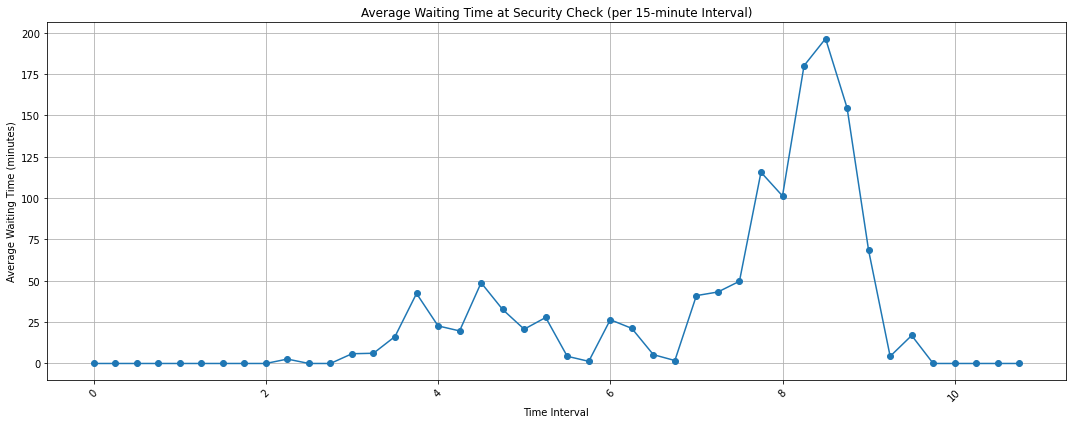

In [16]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(average_waiting_time_df['Time in hour'], average_waiting_time_df['Average Waiting Time'], marker='o')
plt.title('Average Waiting Time at Security Check (per 15-minute Interval)')
plt.xlabel('Time Interval')
plt.ylabel('Average Waiting Time (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()